In [12]:
# load Google Driver
from google.colab import drive
import sys, os
drive.mount('/content/drive')

my_path = '/content/drive/My Drive/Computer Vision/Extensive VisionAI (EVA5)/08_Resnet'
sys.path.append(my_path)
os.listdir(my_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['dataTorchTransformLoad.py',
 'Test_Train.py',
 'Plots.py',
 'GBN_NET.py',
 '__pycache__',
 'outputs',
 '06_Modular_Main.ipynb',
 'VS_NET.py',
 'Resnet.py',
 '02_CIFAR+Resnet.ipynb',
 '01_CIFAR+Baseline.ipynb']

In [13]:
# import

from __future__ import print_function
import torch
import torch.nn as nn
import torch.optim as optim
# import torch.functional as F
import torch.nn.functional as F
from torchvision import datasets, transforms
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
import sys
import random

# import for all the modular codes
import VS_NET
import Test_Train
import Plots
import dataTorchTransformLoad as dtl
import Resnet
#import GBN_NET



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [14]:
# # Modelling options for the loop


# d1 = {'NO L1&L1': [0.,0.,'model'],
#       'L1 Only': [1e-04,0.,'model'], 
#       'L2 Only': [0.,1e-04,'model'],
#       'L1&L2':[1e-04,1e-04,'model'],
#       'GBN Only': [0,0,'model2'],
#       'GBN with L1 and L2':[1e-04,1e-04,'model2']}

#initializers 
dropout_value = 0.05
num_splits=2
EPOCHS = 20
input_ch=3

metric_values = {}
models={}

batch_size_GPU=64
batch_size_CPU=16




In [15]:
# Transforms

transforms_cifar_train = transforms.Compose([
                                          #  transforms.Resize((28, 28)),
                                          #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                          transforms.RandomHorizontalFlip(),
                                          transforms.RandomRotation((-5.0, 5.0),fill=1), 
                                          transforms.ToTensor(),
                                          transforms.Normalize(
                                              [0.49139968, 0.48215841, 0.44653091], 
                                              [0.24703223, 0.24348513, 0.26158784]), # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                           transforms.RandomErasing()
                                          # Note the difference between (0.1307) and (0.1307,)
                                          ])
transforms_cifar_test = transforms.Compose([
                                          #  transforms.Resize((28, 28)),
                                          #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                        #   transforms.RandomRotation((-5.0, 5.0), fill=(1,)), 
                                        #   transforms.RandomHorizontalFlip(0.3),
                                          transforms.ToTensor(),
                                          transforms.Normalize(
                                              [0.49139968, 0.48215841, 0.44653091], 
                                              [0.24703223, 0.24348513, 0.26158784]), # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                          #  transforms.RandomErasing()
                                          # Note the difference between (0.1307) and (0.1307,)
                                          ])

In [16]:
# download data

train = datasets.CIFAR10('./data', train=True, download=True, transform=transforms_cifar_train)
test = datasets.CIFAR10('./data', train=False, download=True, transform=transforms_cifar_test) 

Files already downloaded and verified
Files already downloaded and verified


In [17]:
# Data loader
SEED=1
cuda = torch.cuda.is_available()

torch.cuda.manual_seed(SEED) if cuda else torch.manual_seed(SEED)

dataloader_args=dict(shuffle=True,batch_size=batch_size_GPU, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=batch_size_CPU)

# Train loader
train_loader = torch.utils.data.DataLoader(train,**dataloader_args)
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)


In [18]:
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [19]:
train_transform = transforms.Compose([transforms.ToTensor()])
train_set = torchvision.datasets.CIFAR10('./data', train=True, download=True, transform=train_transform)
    #print(vars(train_set))
print("Shape : ", train_set.data.shape)
print("Mean : ",train_set.data.mean(axis=(0,1,2))/255)
print("Std : ",train_set.data.std(axis=(0,1,2))/255)
print("Min : ",train_set.data.min(axis=(0,1,2))/255)
print("Max : ",train_set.data.max(axis=(0,1,2))/255)

Files already downloaded and verified
Shape :  (50000, 32, 32, 3)
Mean :  [0.49139968 0.48215841 0.44653091]
Std :  [0.24703223 0.24348513 0.26158784]
Min :  [0. 0. 0.]
Max :  [1. 1. 1.]


[['dog' 'horse' 'cat' 'dog' 'deer' 'ship' 'horse' 'bird']
 ['ship' 'plane' 'dog' 'dog' 'cat' 'frog' 'horse' 'car']
 ['plane' 'deer' 'truck' 'horse' 'truck' 'car' 'frog' 'frog']
 ['truck' 'dog' 'bird' 'cat' 'dog' 'dog' 'cat' 'cat']
 ['dog' 'truck' 'car' 'cat' 'horse' 'frog' 'frog' 'frog']
 ['car' 'deer' 'dog' 'truck' 'deer' 'plane' 'deer' 'horse']
 ['car' 'dog' 'deer' 'bird' 'frog' 'bird' 'frog' 'frog']
 ['car' 'dog' 'dog' 'horse' 'car' 'dog' 'plane' 'plane']]


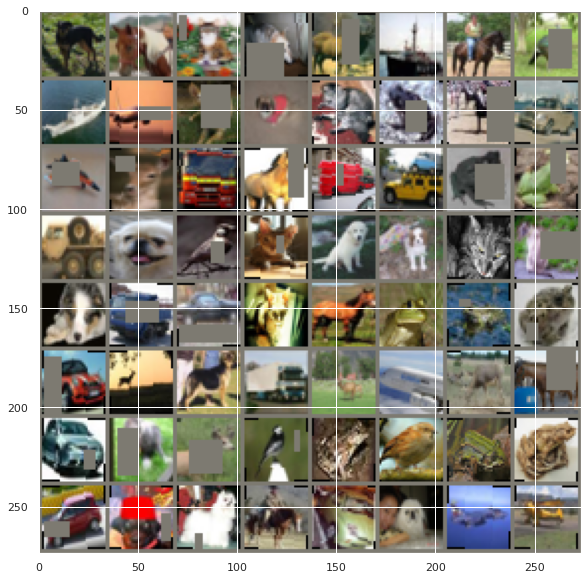

In [20]:
# functions to show an image
def imageshow(img):
    # img = img / 2 + 0.5      #unnormalize
    img[0] = img[0]*0.24703223 + 0.49139968
    img[1] = img[1]*0.24348513 + 0.48215841
    img[2] = img[2]*0.26158784 + 0.44653091
    npimg = img.numpy()
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

random.seed(1)
# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
random.seed(1)
imageshow(torchvision.utils.make_grid(images))
# print labels
# print(' '.join('%5s' % classes[labels[j]] for j in range(64)))
print(np.array([classes[labels[j]] for j in range(64)]).reshape(8,8))

#RESNET

In [21]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Resnet.ResNet18().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

/content/drive/My Drive/Computer Vision/Extensive VisionAI (EVA5)/08_Resnet/Resnet.py:109: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.log_softmax(out)


In [22]:
from torch.optim.lr_scheduler import StepLR
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.05)

In [23]:
exp_name = 'Resnet'

trainer = Test_Train.Trainer(model,device,train_loader,test_loader,optimizer,
                             EPOCHS,scheduler)
train_metric, test_metric = trainer.train(l1_lambda=0, l2_lambda=0)

# save the metrics in dictionary

metric_values[exp_name] = (train_metric, test_metric)

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)
  0%|          | 0/782 [00:00<?, ?it/s]

EPOCH: 0
learning rate  [0.01]


/content/drive/My Drive/Computer Vision/Extensive VisionAI (EVA5)/08_Resnet/Resnet.py:109: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.log_softmax(out)
Loss=1.254577875137329 Batch_id=781 Accuracy=48.67: 100%|██████████| 782/782 [00:43<00:00, 18.17it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.0231, Accuracy: 6408/10000 (64.08%)

EPOCH: 1
learning rate  [0.01]


Loss=0.9310378432273865 Batch_id=781 Accuracy=66.07: 100%|██████████| 782/782 [00:43<00:00, 18.16it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7591, Accuracy: 7457/10000 (74.57%)

EPOCH: 2
learning rate  [0.01]


Loss=0.20157396793365479 Batch_id=781 Accuracy=73.33: 100%|██████████| 782/782 [00:42<00:00, 18.22it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7025, Accuracy: 7601/10000 (76.01%)

EPOCH: 3
learning rate  [0.01]


Loss=0.37254342436790466 Batch_id=781 Accuracy=76.90: 100%|██████████| 782/782 [00:42<00:00, 18.27it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5799, Accuracy: 8036/10000 (80.36%)

EPOCH: 4
learning rate  [0.01]


Loss=1.201364278793335 Batch_id=781 Accuracy=79.66: 100%|██████████| 782/782 [00:42<00:00, 18.28it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5305, Accuracy: 8248/10000 (82.48%)

EPOCH: 5
learning rate  [0.01]


Loss=0.3431603014469147 Batch_id=781 Accuracy=81.69: 100%|██████████| 782/782 [00:43<00:00, 18.16it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5172, Accuracy: 8230/10000 (82.30%)

EPOCH: 6
learning rate  [2.5e-05]


Loss=0.5361599922180176 Batch_id=781 Accuracy=86.43: 100%|██████████| 782/782 [00:42<00:00, 18.33it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3881, Accuracy: 8686/10000 (86.86%)

EPOCH: 7
learning rate  [0.0005]


Loss=0.4329599142074585 Batch_id=781 Accuracy=87.77: 100%|██████████| 782/782 [00:42<00:00, 18.26it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3818, Accuracy: 8728/10000 (87.28%)

EPOCH: 8
learning rate  [0.0005]


Loss=0.39475226402282715 Batch_id=781 Accuracy=88.41: 100%|██████████| 782/782 [00:42<00:00, 18.22it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3709, Accuracy: 8755/10000 (87.55%)

EPOCH: 9
learning rate  [0.0005]


Loss=0.4413543939590454 Batch_id=781 Accuracy=88.82: 100%|██████████| 782/782 [00:43<00:00, 18.09it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3714, Accuracy: 8759/10000 (87.59%)

EPOCH: 10
learning rate  [0.0005]


Loss=0.570123553276062 Batch_id=781 Accuracy=89.10: 100%|██████████| 782/782 [00:43<00:00, 18.16it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3646, Accuracy: 8785/10000 (87.85%)

EPOCH: 11
learning rate  [0.0005]


Loss=0.24405717849731445 Batch_id=781 Accuracy=89.30: 100%|██████████| 782/782 [00:43<00:00, 18.11it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3575, Accuracy: 8803/10000 (88.03%)

EPOCH: 12
learning rate  [1.25e-06]


Loss=0.9312052726745605 Batch_id=781 Accuracy=89.69: 100%|██████████| 782/782 [00:43<00:00, 18.13it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3595, Accuracy: 8821/10000 (88.21%)

EPOCH: 13
learning rate  [2.5e-05]


Loss=0.5457620620727539 Batch_id=781 Accuracy=89.89: 100%|██████████| 782/782 [00:42<00:00, 18.19it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3560, Accuracy: 8830/10000 (88.30%)

EPOCH: 14
learning rate  [2.5e-05]


Loss=0.4316939413547516 Batch_id=781 Accuracy=89.82: 100%|██████████| 782/782 [00:43<00:00, 18.04it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3571, Accuracy: 8823/10000 (88.23%)

EPOCH: 15
learning rate  [2.5e-05]


Loss=0.397439569234848 Batch_id=781 Accuracy=89.75: 100%|██████████| 782/782 [00:43<00:00, 17.96it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3551, Accuracy: 8830/10000 (88.30%)

EPOCH: 16
learning rate  [2.5e-05]


Loss=0.15528219938278198 Batch_id=781 Accuracy=89.73: 100%|██████████| 782/782 [00:43<00:00, 18.12it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3537, Accuracy: 8836/10000 (88.36%)

EPOCH: 17
learning rate  [2.5e-05]


Loss=0.17665335536003113 Batch_id=781 Accuracy=89.94: 100%|██████████| 782/782 [00:43<00:00, 17.98it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3553, Accuracy: 8832/10000 (88.32%)

EPOCH: 18
learning rate  [6.250000000000001e-08]


Loss=0.14569824934005737 Batch_id=781 Accuracy=89.96: 100%|██████████| 782/782 [00:43<00:00, 18.08it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3548, Accuracy: 8832/10000 (88.32%)

EPOCH: 19
learning rate  [1.25e-06]


Loss=0.26297152042388916 Batch_id=781 Accuracy=89.89: 100%|██████████| 782/782 [00:43<00:00, 18.14it/s]



Test set: Average loss: 0.3573, Accuracy: 8830/10000 (88.30%)



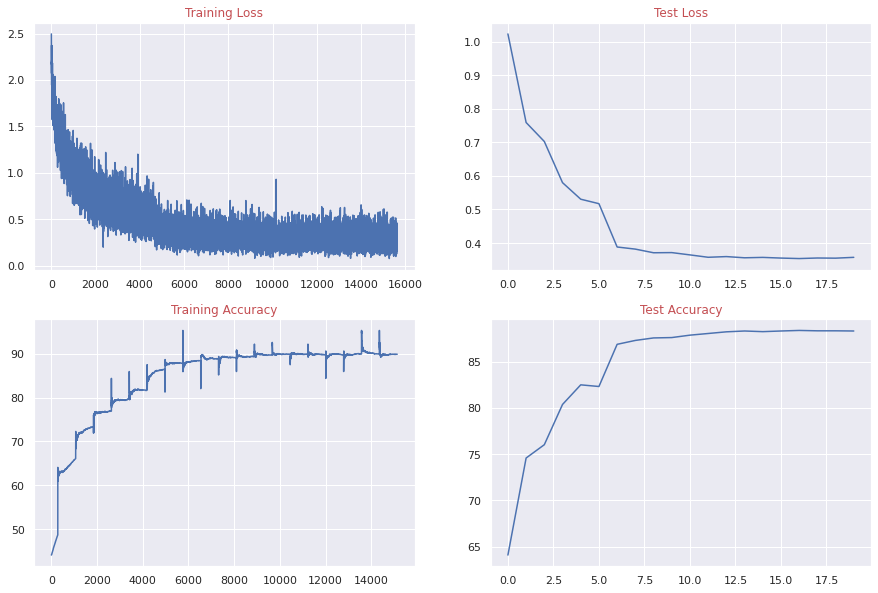

In [24]:
Plots.plot_metrics(train_metric, test_metric)

In [ ]:
Plots.multi_plots_loss(metric_values)
Plots.multi_plots_acc(metric_values)

# Plot misclassified

In [ ]:
# plot_misclassified(model2,test_loader,device)

Plots.plot_misclassified(model2,test_loader,device)